In [1]:
import os
import shutil
import itertools
from glob import glob
import random
from collections import Counter
import numpy as np
import pandas as pd

import keras
from keras import layers
from keras import models
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.utils import plot_model
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
from sklearn.model_selection import KFold
from scipy import interp
from itertools import cycle

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


Using TensorFlow backend.


In [2]:
plt.rcParams['figure.figsize'] = [15, 10]

In [3]:
os.chdir('C:\\Users\\Christopher\\Machine_Learning')

# Load Data

In [4]:
x_train = np.load('datasets/intel-image-classification/whole_split/x_train.npy')
y_train = np.load('datasets/intel-image-classification/whole_split/y_train.npy')
x_val = np.load('datasets/intel-image-classification/whole_split/x_val.npy')
y_val = np.load('datasets/intel-image-classification/whole_split/y_val.npy')
x_test = np.load('datasets/intel-image-classification/whole_split/x_test.npy')
y_test = np.load('datasets/intel-image-classification/whole_split/y_test.npy')

# Dataset Distribution

In [5]:
train_count=[]
val_count=[]
whole_count=[]

print('TRAINING SET')
files= os.listdir("datasets/intel-image-classification/whole_split/train")
for type in files:
    count = os.listdir('datasets/intel-image-classification/whole_split/train/'+type+'/')
    print(type+ "  "+ str(len(count)))
    train_count.append(len(count))
print()

print('VALIDATION SET')
files= os.listdir('datasets/intel-image-classification/whole_split/val')
for type in files:
    count = os.listdir('datasets/intel-image-classification/whole_split/val/'+type+'/')
    print(type+ "  "+ str(len(count)))
    val_count.append(len(count))

print()

print('TEST SET')
files= os.listdir('datasets/intel-image-classification/whole_split/test')

for type in files:
    count = os.listdir('datasets/intel-image-classification/whole_split/test/'+type+'/')
    print(type+ "  "+ str(len(count)))
    whole_count.append(len(count))

TRAINING SET
buildings  1839
forest  1921
glacier  2069
mountain  2125
sea  1948
street  2018

VALIDATION SET
buildings  525
forest  549
glacier  591
mountain  607
sea  556
street  576

TEST SET
buildings  264
forest  275
glacier  297
mountain  305
sea  280
street  289


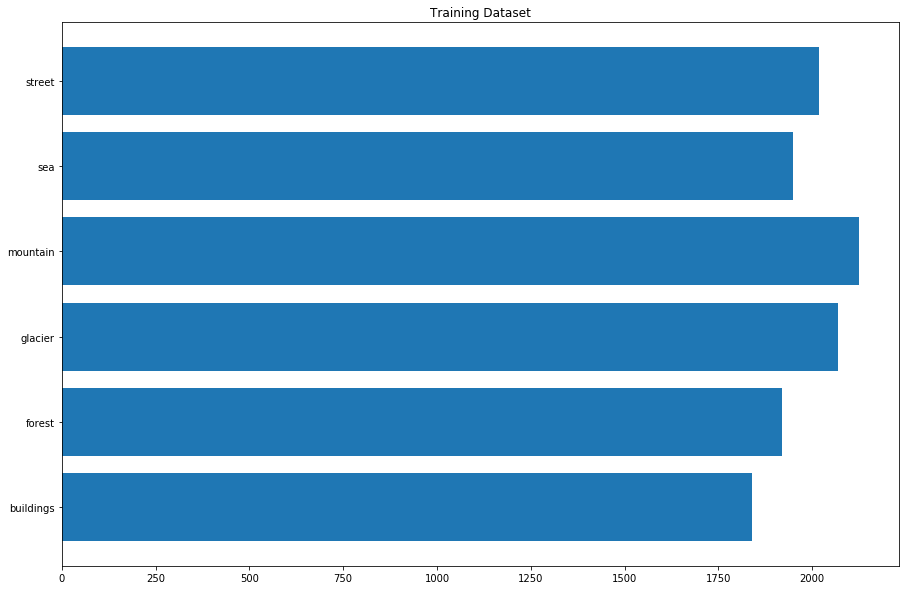

In [6]:
plt.barh(files, train_count,)
plt.title('Training Dataset')
plt.show()

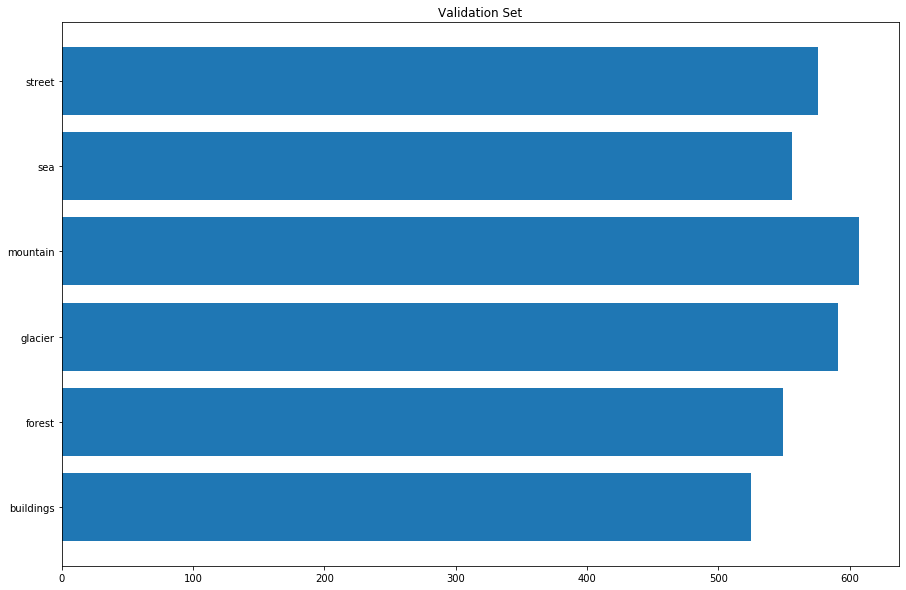

In [7]:
plt.barh(files, val_count,)
plt.title('Validation Set')
plt.show()

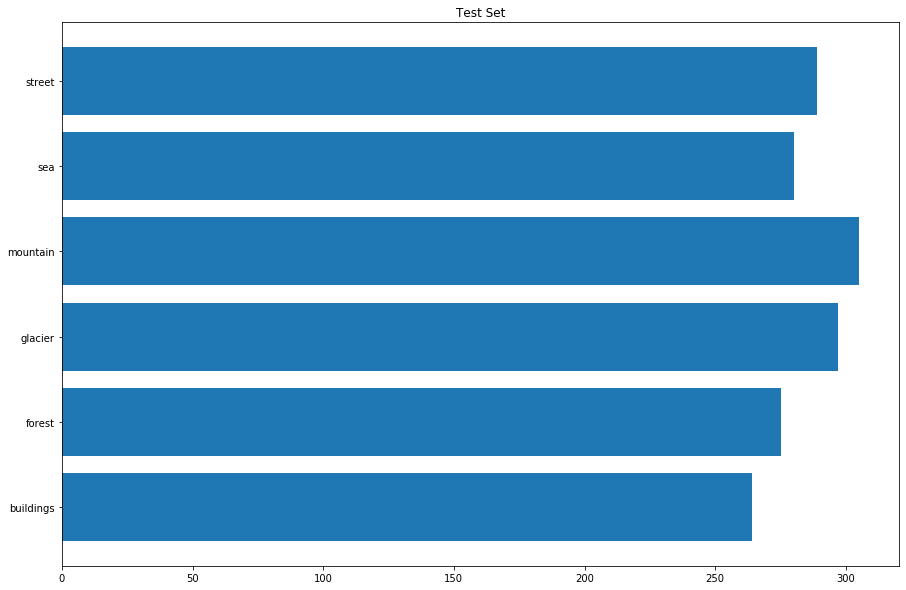

In [8]:
plt.barh(files, whole_count,)
plt.title('Test Set')
plt.show()

In [9]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import pandas as pd

In [10]:
def fix_for_resample(x,y):
    x_reshape=x.reshape(x.shape[0], -1)
    y_reshape=y.argmax(axis=1)
    return x_reshape,y_reshape

In [11]:
ada = RandomOverSampler(random_state = 27)

In [12]:
x_train, y_train = fix_for_resample(x_train, y_train)
x_val, y_val = fix_for_resample(x_val, y_val)

In [13]:
x_train_res, y_train_res = ada.fit_resample(x_train, y_train)
x_val_res, y_val_res = ada.fit_resample(x_val, y_val)

In [14]:
x_train_expand  = x_train_res.reshape(x_train_res.shape[0], 150, 150, 3)
y_train_res_bin = label_binarize(y_train_res,classes=np.arange(0,6,1))

x_val_expand  = x_val_res.reshape(x_val_res.shape[0], 150, 150, 3)
y_val_res_bin = label_binarize(y_val_res,classes=np.arange(0,6,1))

In [15]:
np.save('datasets/intel-image-classification/SMOTE_x_train.npy', x_train_expand)
np.save('datasets/intel-image-classification/SMOTE_y_train.npy', y_train_res_bin)
np.save('datasets/intel-image-classification/SMOTE_x_val.npy', x_val_expand)
np.save('datasets/intel-image-classification/SMOTE_y_val.npy', y_val_res_bin)

# Model

In [16]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, AveragePooling2D
model = models.Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', ))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', ))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', ))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(.50))
model.add(Dense(512, activation='relu',))
model.add(Dense(6, activation='softmax'))

In [17]:
print(model.summary())
opt = Adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

In [19]:
history = model.fit(x_train_expand, y_train_res_bin, batch_size=32, epochs=50, validation_data=(x_val_expand,y_val_res_bin) )

Train on 12750 samples, validate on 3642 samples
Epoch 1/50
12750/12750 [==============================] - 33s 3ms/step - loss: 2.0840 - accuracy: 0.4613 - val_loss: 1.0308 - val_accuracy: 0.5832
Epoch 2/50
12750/12750 [==============================] - 22s 2ms/step - loss: 1.0219 - accuracy: 0.5947 - val_loss: 0.8647 - val_accuracy: 0.6837
Epoch 3/50
12750/12750 [==============================] - 22s 2ms/step - loss: 0.8494 - accuracy: 0.6728 - val_loss: 0.7396 - val_accuracy: 0.7155
Epoch 4/50
12750/12750 [==============================] - 22s 2ms/step - loss: 0.7097 - accuracy: 0.7398 - val_loss: 0.6911 - val_accuracy: 0.7576
Epoch 5/50
12750/12750 [==============================] - 22s 2ms/step - loss: 0.6269 - accuracy: 0.7689 - val_loss: 0.5883 - val_accuracy: 0.7773
Epoch 6/50
12750/12750 [==============================] - 22s 2ms/step - loss: 0.5583 - accuracy: 0.8001 - val_loss: 0.5434 - val_accuracy: 0.7976
Epoch 7/50
12750/12750 [==============================] - 22s 2ms/ste

In [20]:
probs = model.predict(x_test)
y_test = y_test.argmax(axis=1)

In [21]:
probs=probs.argmax(axis=1)

# Analysis

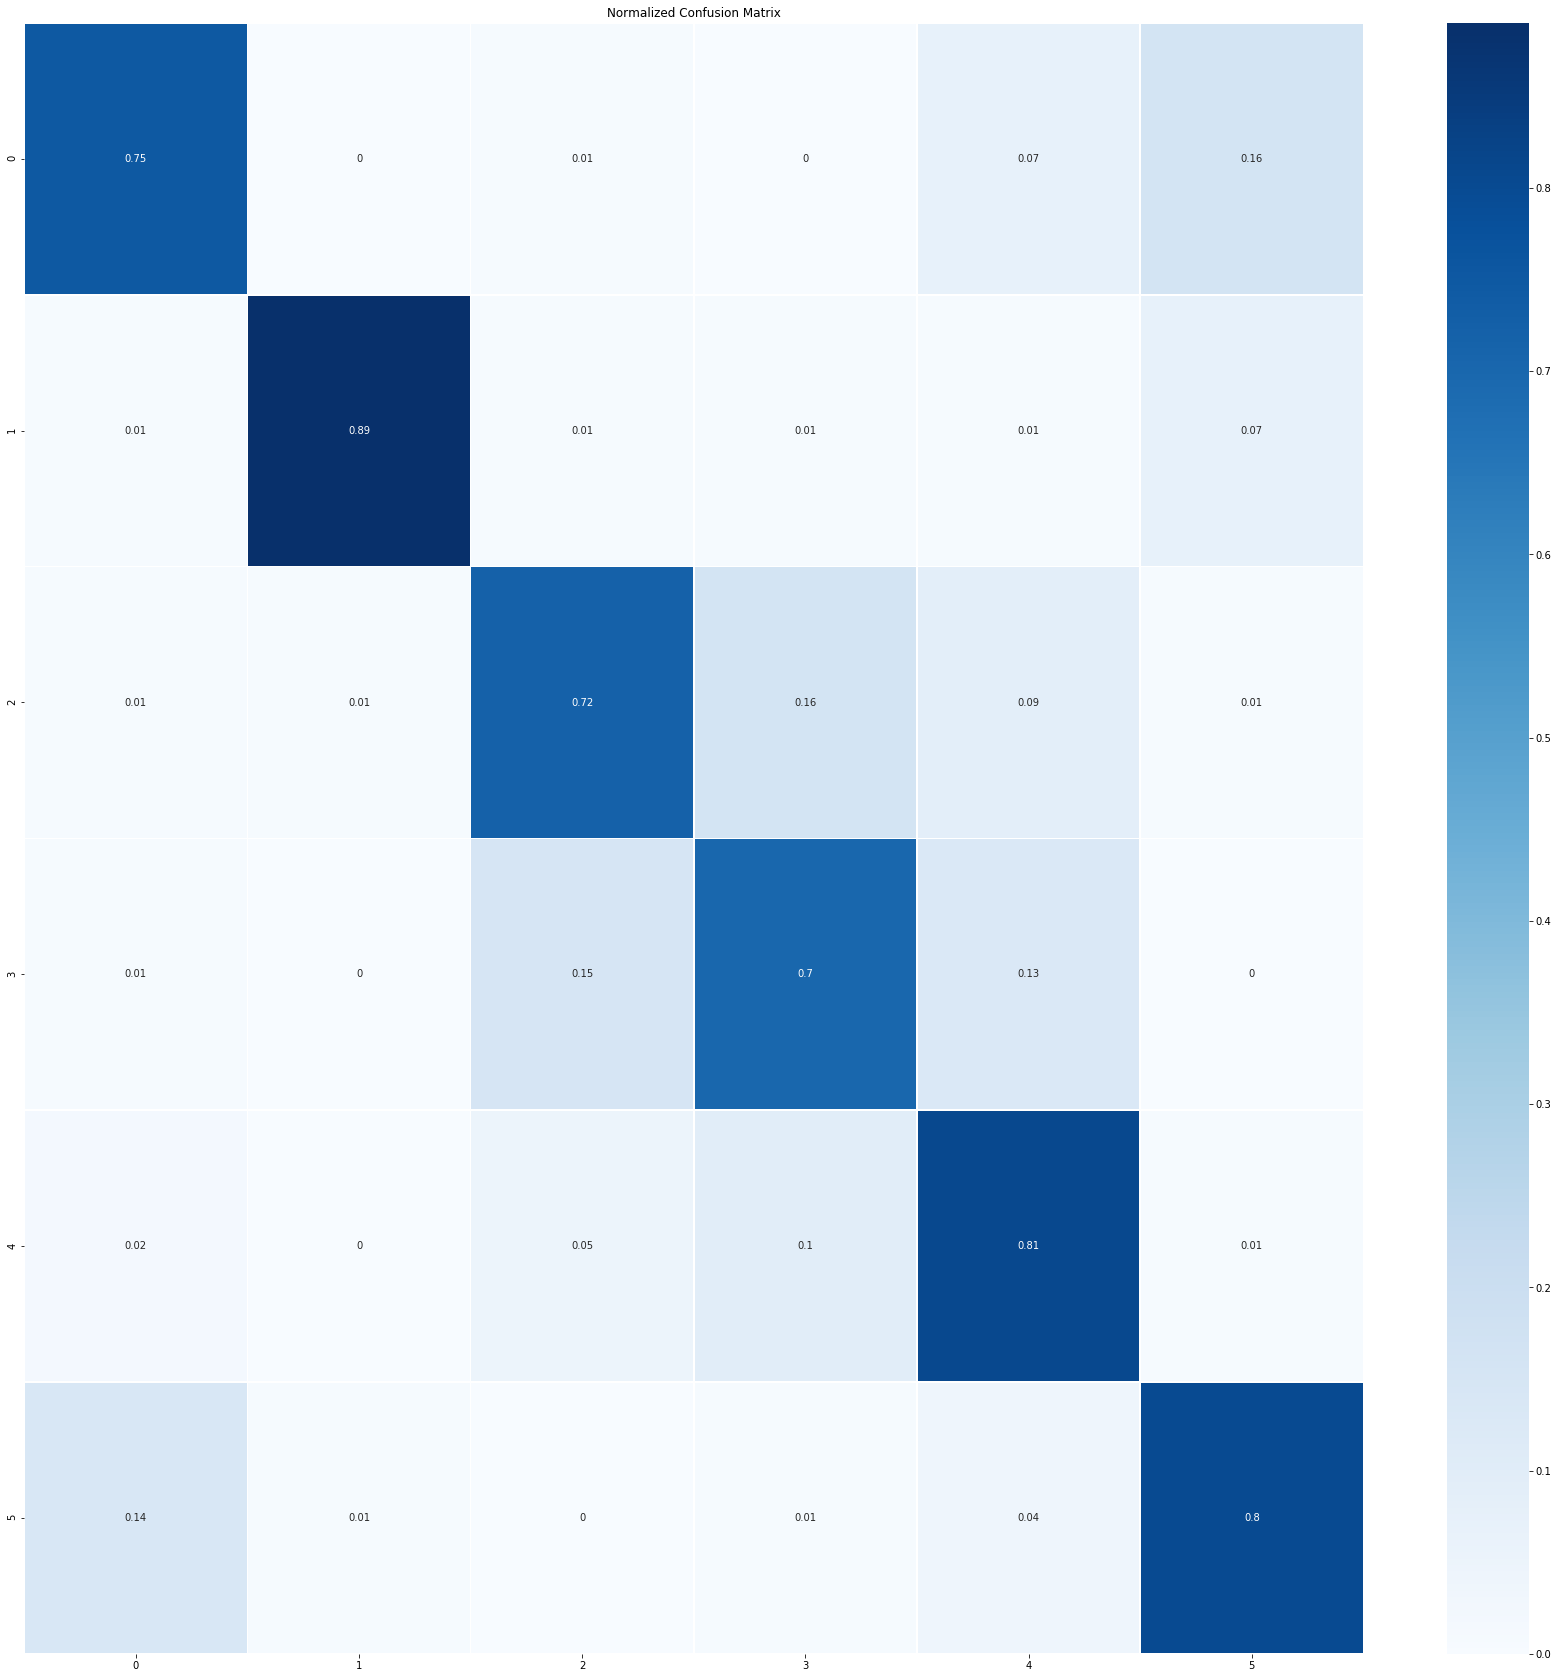

In [22]:
con_matrix = confusion_matrix(y_test, probs,)
con_matrix = con_matrix / con_matrix.sum(axis=1, keepdims=True)
con_matrix = np.around(con_matrix, 2)
plt.figure(figsize=(30,30))
plt.title('Normalized Confusion Matrix')
sns.heatmap(con_matrix, annot=True, linewidths=.75, cmap="Blues")

In [23]:
print(classification_report(y_test, probs, digits=4))

              precision    recall  f1-score   support

           0     0.7795    0.7500    0.7645       264
           1     0.9760    0.8873    0.9295       275
           2     0.7616    0.7205    0.7405       297
           3     0.7181    0.7016    0.7098       305
           4     0.6888    0.8143    0.7463       280
           5     0.7770    0.7958    0.7863       289

    accuracy                         0.7766      1710
   macro avg     0.7835    0.7783    0.7795      1710
weighted avg     0.7818    0.7766    0.7778      1710



In [24]:
y_test = label_binarize(y_test,classes=np.arange(0,7,1))
y_score = label_binarize(probs, classes=np.arange(0,7,1))

C:\Users\Christopher\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


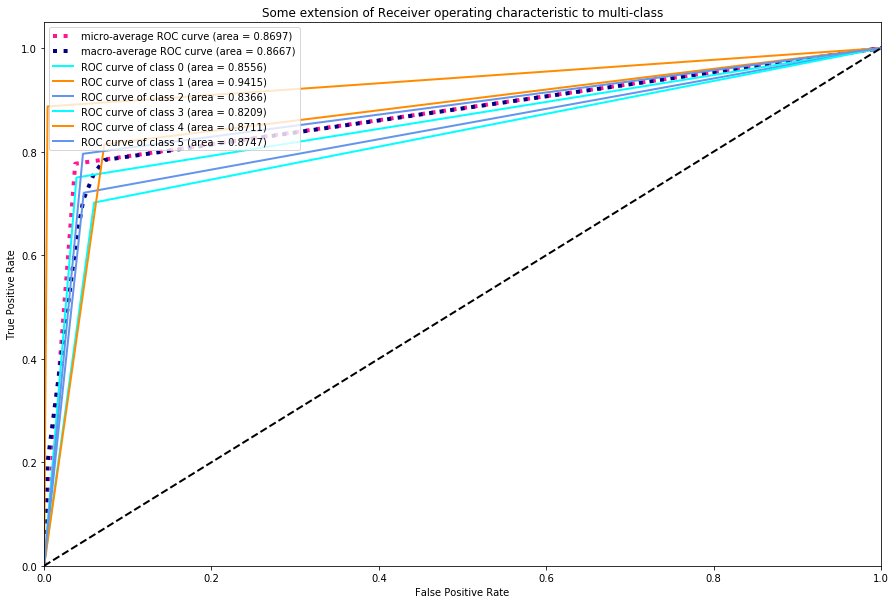

In [25]:
n_classes=6
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.4f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="upper left")
plt.show()

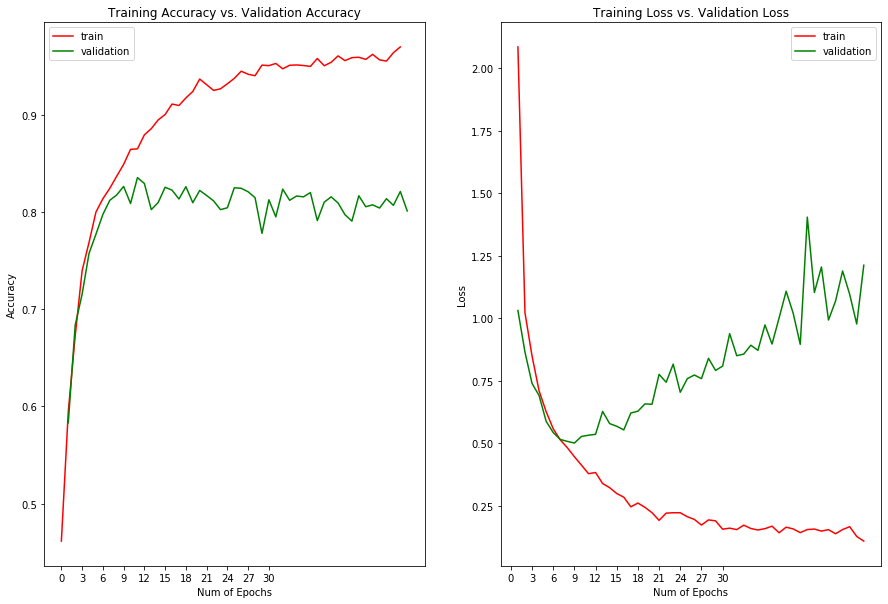

In [26]:
# summarize history for accuracy
plt.subplot(1, 2 ,1)
plt.plot(np.arange(0, len(history.history['accuracy'])), history.history['accuracy'], 'r')
plt.plot(np.arange(1, len(history.history['val_accuracy'])+1), history.history['val_accuracy'], 'g')
plt.xticks(np.arange(0, 30+1, 30/10))
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Num of Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'], loc='best')
  
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(history.history['loss'])+1), history.history['loss'], 'r')
plt.plot(np.arange(1, len(history.history['val_loss'])+1), history.history['val_loss'], 'g')
plt.xticks(np.arange(0, 30+1, 30/10))
plt.title('Training Loss vs. Validation Loss')
plt.xlabel('Num of Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='best')
  
  
plt.show()

In [27]:
df = pd.DataFrame((history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss'])).T
df.columns=['Acc', 'Val_Acc', 'Loss', 'Val_Loss']
df.index.name='Epoch'
df.index=np.arange(1,51,1)
df

,Acc,Val_Acc,Loss,Val_Loss
1,0.461333,0.583196,2.084042,1.030849
2,0.594745,0.683690,1.021907,0.864665
3,0.672784,0.715541,0.849355,0.739553
4,0.739765,0.757551,0.709659,0.691127
5,0.768863,0.777320,0.626932,0.588327
6,0.800078,0.797639,0.558339,0.543351
7,0.813804,0.812191,0.514019,0.515627
8,0.824549,0.817683,0.482840,0.508096
9,0.837020,0.826469,0.446686,0.501357
10,0.849176,0.808896,0.413325,0.527683


In [28]:
df.to_csv('CSVs/intel-img/adam/CNN/SMOTE.csv')

In [29]:
model.save('models/intel-image/adam/CNN/SMOTE.h5')